# Q2 CNNs and Transformers [6 points]

- Srihari Bandarupalli
- 2021112006

In [1]:
# import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
# import multiprocessing

from sklearn.metrics import accuracy_score

import torch
import torchvision

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

/home/srihari/miniconda3/envs/conda_cv/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device,torch.__version__,torch.cuda.device_count()

('cpu', '2.2.0', 0)

In [3]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## CNN

### Dataset and Dataloader

In [5]:
import torchvision.transforms as transforms
from torchvision import datasets

def data_get_load(batch_size=64):
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])
    
    # Create datasets for training & validation, download if necessary
    training_set = datasets.MNIST('./data', train=True, transform=transform, download=True)
    validation_set = datasets.MNIST('./data', train=False, transform=transform, download=True)
    
    # Create data loaders for our datasets; shuffle for training, not for validation
    training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)
    
    # Report split sizes
    print('Training set has {} instances'.format(len(training_set)))
    print('Validation set has {} instances'.format(len(validation_set)))

    return training_loader,validation_loader

Training set has 60000 instances
Validation set has 10000 instances
4  7  2  4  5  8  0  8


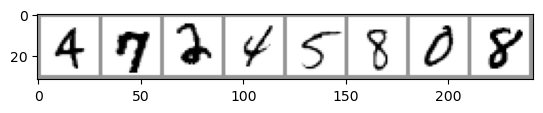

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

training_loader,validation_loader = data_get_load(8)

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(str(labels[j].numpy()) for j in range(8)))

### Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet()
model.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

In [9]:
optimizer = torch.optim.Adam(model.parameters())

### Trainer

In [10]:
# train One epoch

def train_one_epoch(model,train_loader,loss_fn,optimizer,device,epoch_index,tb_writer,wandb=None,write = True):

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    running_loss =0
    last_loss = 0
    losses=[]
    for i,data in enumerate(training_loader):
        inputs,labels = data
        inputs,labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()        
        outputs=model(inputs)
        loss = loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        if wandb != None:
            wandb.log({"train_loss": loss.item()})
        running_loss +=loss.item()
        losses.append(loss.item())
        if i%1000 == 999:
            last_loss = running_loss/100
            print(f"{i+1}th batch => {last_loss}")
            if(write):
                tb_x = epoch_index * len(training_loader)
                tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    if last_loss==0:
        return np.mean(np.array(losses))
    return last_loss

In [11]:
# test one epoch
def test_one_epoch(model,test_loader,loss_fn,device,wandb=None):

    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    running_loss =0
    last_loss = 0
    correct = 0
    with torch.no_grad():
        for i,data in enumerate(test_loader):
            inputs,labels = data
            inputs,labels = inputs.to(device), labels.to(device)

            outputs=model(inputs)
            
            loss = loss_fn(outputs,labels)
            running_loss +=loss.item()
            _,preds = torch.max(outputs,1)
            correct += (preds == labels).sum().item()
            # if wandb!=None:
                
                # Accuracy(preds, labels)
                # # precision(preds, labels)
                # # recall(preds, labels)
                # # f1(preds, labels)
                # # wandb.log({"accuracy": accuracy.compute(), "precision": precision.compute(), "recall": recall.compute(), "f1": f1.compute()})
                # wandb.log({"vloss":loss.item(),"accuracy": ((preds == labels).sum())/len(labels).compute()})
    
                # # Reset metrics
                # Accuracy.reset()
                # # precision.reset()
                # # recall.reset()
                # # f1.reset()
    accuracy = correct/len(test_loader.dataset)
    return running_loss/len(test_loader.dataset) , accuracy    

In [12]:
# # Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/mnist_trainer_{}'.format(timestamp))
# epoch_number = 0

# EPOCHS = 2

# best_vloss = 1_000_000.

# for epoch in range(EPOCHS):
    
#     print('EPOCH {}:'.format(epoch_number + 1))
    
#     avg_loss = train_one_epoch(model,training_loader,loss_fn,optimizer,device,epoch_number, writer)
#     avg_vloss,v_acc = test_one_epoch(model,validation_loader,loss_fn,device)
    
#     print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

#     # Log the running loss averaged per batch
#     # for both training and validation
#     writer.add_scalars('Training vs. Validation Loss',
#                     { 'Training' : avg_loss, 'Validation' : avg_vloss },
#                     epoch_number + 1)
#     writer.flush()

#     # Track best performance, and save the model's state
#     if avg_vloss < best_vloss:
#         best_vloss = avg_vloss
#         model_path = './models/model_{}_{}'.format(timestamp, epoch_number)
#         torch.save(model.state_dict(), model_path)

#     epoch_number += 1

In [13]:
saved_model = LeNet()
saved_model.load_state_dict(torch.load("./models/model_20240306_121901_0", map_location=device))
saved_model.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
saved_model.eval()

correct =0
# Disable gradient computation and reduce memory consumption.
with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs,vlabels=vinputs.to(device),vlabels.to(device)
        voutputs = saved_model(vinputs)

        _,predicted = torch.max(voutputs,1)
        correct += (predicted == vlabels).sum().item()
accuracy = correct/len(validation_loader.dataset)
print(accuracy)

0.987


### wandb

In [15]:
import wandb
from pprint import pprint

In [16]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sriharib128. Use `wandb login --relogin` to force relogin


True

In [17]:
run = wandb.init(project="CV_A1_Q2",name = "1st run")
wandb.config.learning_rate = 0.001
wandb.config.batch_size = 64
wandb.config.epoch = 10
wandb.config.optimizer = "adam"
pprint(wandb.config)

{'learning_rate': 0.001, 'batch_size': 64, 'epoch': 10, 'optimizer': 'adam'}


In [18]:
model = LeNet()
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=wandb.config.learning_rate)

In [19]:
training_loader,validation_loader = data_get_load(wandb.config.batch_size)

Training set has 60000 instances
Validation set has 10000 instances


In [20]:
len(validation_loader)

157

In [21]:
# from torchmetrics import Accuracy, Precision, Recall, F1Score
# # Initialize metrics
# num_classes = 10
# accuracy = Accuracy(task='multiclass',num_classes=num_classes).to(device)
# precision = Precision(task='multiclass', average='macro', num_classes=num_classes).to(device)
# recall = Recall(task='multiclass', average='macro', num_classes=num_classes).to(device)
# f1 = F1Score(task='multiclass', average='macro', num_classes=num_classes).to(device)

In [22]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
best_vloss = 1_000_000.
# Training loop
for epoch_number in range(wandb.config.epoch):  # Number of epochs
    correct = 0
    total = 0
    print('EPOCH {}:'.format(epoch_number + 1))
    avg_loss = train_one_epoch(model,training_loader,loss_fn,optimizer,device,epoch_number,None,None,write=False)
    avg_vloss,v_acc = test_one_epoch(model,validation_loader,loss_fn,device,None)

    wandb.log({"train_loss":avg_loss,"vloss":avg_vloss,"accuracy":v_acc})
    
    print('LOSS train {} valid {} ACC {}'.format(avg_loss, avg_vloss,v_acc))

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = './models/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
        print(f"saved model to {model_path}")

# exort to ONNX and save in Netron for Vizualization
wandb.save("model.pth")

# Finish the run
run.finish()

EPOCH 1:
100th batch => 1.0806842792034148
200th batch => 0.278742106705904
300th batch => 0.18545835487544537
400th batch => 0.14566997803747653
500th batch => 0.13438145775347948
600th batch => 0.12050811596214771
700th batch => 0.10242413160391152
800th batch => 0.09857013694010675
900th batch => 0.07522635676898062
LOSS train 0.07522635676898062 valid 0.0011488795249490068 ACC 0.9773
saved model to ./models/model_20240307_005452_0
EPOCH 2:
100th batch => 0.07315306286327541
200th batch => 0.0692412838852033
300th batch => 0.07584246435202659
400th batch => 0.06203115314245224
500th batch => 0.05894677390344441
600th batch => 0.06735840604756958
700th batch => 0.06499053363222629
800th batch => 0.05043961589224637
900th batch => 0.05441587164299563
LOSS train 0.05441587164299563 valid 0.0006031600922862708 ACC 0.9875
saved model to ./models/model_20240307_005452_1
EPOCH 3:
100th batch => 0.04953925197711215
200th batch => 0.04277902920497581
300th batch => 0.047060423730872575
400th

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▆▆▇▇█▅▇██
train_loss,█▅▅▄▄▂▂▂▁▁
vloss,█▂▂▂▂▁▃▂▁▂
accuracy,0.9906
train_loss,0.01834
vloss,0.00058


## Hyperparameter tuning

In [15]:
def build_optimizer(model, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(model.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(model.parameters(),
                               lr=learning_rate)
    return optimizer

In [22]:
configs_sweep=[]
accuracies_sweep=[]
def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        pprint(wandb.config)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        training_loader,validation_loader = data_get_load(wandb.config.batch_size)
        
        model = LeNet()
        model.to(device)
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = build_optimizer(model, config.optimizer, config.learning_rate)

        for epoch_number in range(config.epochs):
            avg_loss = train_one_epoch(model,training_loader,loss_fn,optimizer,device,epoch_number,None,None,write=False)
            avg_vloss,v_acc = test_one_epoch(model,validation_loader,loss_fn,device,None)
            print('EPOCH {}  LOSS train {} valid {} ACC {}'.format(epoch_number,avg_loss, avg_vloss,v_acc))
        
            wandb.log({"train_loss":avg_loss,"vloss":avg_vloss,"accuracy":v_acc})
        configs_sweep.append(wandb.config)
        accuracies_sweep.append(v_acc)

In [23]:
# Sweep Configuration
sweep_config = {
    'method': 'random', # Use random search strategy
    'metric': { # The metric that you want to optimize
        'name': 'v_loss',
        'goal': 'minimize'
    },
    'parameters': { # The hyperparameters to tune
        'learning_rate': {  # Learning rate for the optimizer
            'values': [0.001,  0.01,  0.1]
        },
        'optimizer': {  # The optimizer to use
            'values': ['sgd', 'adam']
        },
        # 'dropout': {    # The dropout to use
        #     'values': [0.2,  0.3,  0.5]
        # },
        'batch_size': {    # The batch size
            'values': [8, 32,  64,  128]
        },
        'epochs': {    # The number of epochs
            'values': [1, 2, 5]}
    }
}

In [24]:
# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="CV_A1_Q2")

Create sweep with ID: n67d31si
Sweep URL: https://wandb.ai/sriharib128/CV_A1_Q2/sweeps/n67d31si


In [25]:
wandb.agent(sweep_id, function=train, count=6)

wandb: Agent Starting Run: sde5nc2g with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'batch_size': 8, 'epochs': 2, 'learning_rate': 0.01, 'optimizer': 'sgd'}
Training set has 60000 instances
Validation set has 10000 instances
991th batch => 6.199817708885821
1991th batch => 1.9512392409095447
2991th batch => 1.4760686647960757
3991th batch => 1.4342516511253416
4991th batch => 1.363316169644786
5991th batch => 1.0689968463997501
6991th batch => 0.9770755575004568
EPOCH 0  LOSS train 0.9770755575004568 valid 0.009310698428575875 ACC 0.9801
991th batch => 0.8658552823110471
1991th batch => 0.9081417675380521
2991th batch => 0.8081263348053176
3991th batch => 0.8740566581206304
4991th batch => 0.8828560253883018
5991th batch => 0.6761636387081168
6991th batch => 0.7688354334256431
EPOCH 1  LOSS train 0.7688354334256431 valid 0.010729170000831527 ACC 0.9772


accuracy,█▁
train_loss,█▁
vloss,▁█
accuracy,0.9772
train_loss,0.76884
vloss,0.01073


wandb: Agent Starting Run: 5d5sx3tb with config:
wandb: 	batch_size: 64
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'batch_size': 64, 'epochs': 2, 'learning_rate': 0.01, 'optimizer': 'adam'}
Training set has 60000 instances
Validation set has 10000 instances
991th batch => 5.9535355256717954
1991th batch => 3.643395198010767
2991th batch => 3.246582798172531
3991th batch => 3.1055301993461852
4991th batch => 2.992721924104635
5991th batch => 3.450461768097903
6991th batch => 2.782694114650494
EPOCH 0  LOSS train 2.782694114650494 valid 0.004004671387956477 ACC 0.9382
991th batch => 2.464102068541033
1991th batch => 2.6414060895377394
2991th batch => 3.8021285598175405
3991th batch => 2.8518025973479326
4991th batch => 2.76539727376934
5991th batch => 2.435629045981859
6991th batch => 2.917860223295287
EPOCH 1  LOSS train 2.917860223295287 valid 0.00445732772985939 ACC 0.9338


accuracy,█▁
train_loss,▁█
vloss,▁█
accuracy,0.9338
train_loss,2.91786
vloss,0.00446


wandb: Agent Starting Run: gskk3bky with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'batch_size': 8, 'epochs': 5, 'learning_rate': 0.01, 'optimizer': 'sgd'}
Training set has 60000 instances
Validation set has 10000 instances
991th batch => 5.555144281192334
1991th batch => 1.9606740361348238
2991th batch => 1.6434143149103055
3991th batch => 1.3617520053270709
4991th batch => 1.2111913919699646
5991th batch => 1.0585869540745398
6991th batch => 0.9975825737698892
EPOCH 0  LOSS train 0.9975825737698892 valid 0.011156678332335133 ACC 0.9759
991th batch => 0.8965585691227651
1991th batch => 0.8465718136889282
2991th batch => 0.875246096716833
3991th batch => 1.0381276281927228
4991th batch => 0.8737072891670356
5991th batch => 0.8787772647239762
6991th batch => 0.7612336578960313
EPOCH 1  LOSS train 0.7612336578960313 valid 0.01093846969395756 ACC 0.9752
991th batch => 0.7473053605409187
1991th batch => 0.7602576802508585
2991th batch => 0.7190579896600253
3991th batch => 0.7655185304154587
4991th batch => 0.7775383908089682
5991th batch => 0.8670465260989808
6991th bat

accuracy,▂▁█▇▇
train_loss,█▄▆▁▄
vloss,█▇▄▁▅
accuracy,0.9817
train_loss,0.77372
vloss,0.01033


wandb: Agent Starting Run: md0ua9ae with config:
wandb: 	batch_size: 128
wandb: 	epochs: 2
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'batch_size': 128, 'epochs': 2, 'learning_rate': 0.001, 'optimizer': 'sgd'}
Training set has 60000 instances
Validation set has 10000 instances
991th batch => 18.251741362810137
1991th batch => 3.6916667104233056
2991th batch => 2.225923065857496
3991th batch => 1.6432018884108401
4991th batch => 1.3863097810960607
5991th batch => 1.262583292920026
6991th batch => 1.0538932435296011
EPOCH 0  LOSS train 1.0538932435296011 valid 0.0005787050933082355 ACC 0.9766
991th batch => 0.8185956264671403
1991th batch => 0.8079232912659791
2991th batch => 0.7871296330192127
3991th batch => 0.8793787902929762
4991th batch => 0.8212653600725752
5991th batch => 0.7263649462335888
6991th batch => 0.6841008702052204
EPOCH 1  LOSS train 0.6841008702052204 valid 0.0004645774460863322 ACC 0.9808


accuracy,▁█
train_loss,█▁
vloss,█▁
accuracy,0.9808
train_loss,0.6841
vloss,0.00046


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cle36q8b with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'batch_size': 32, 'epochs': 5, 'learning_rate': 0.1, 'optimizer': 'adam'}
Training set has 60000 instances
Validation set has 10000 instances
991th batch => 43.176880449056625
1991th batch => 23.25671637058258
2991th batch => 23.26226585149765
3991th batch => 23.29083756685257
4991th batch => 23.300664513111116
5991th batch => 23.28980432987213
6991th batch => 23.253890569210053
EPOCH 0  LOSS train 23.253890569210053 valid 0.07289276967048645 ACC 0.0974
991th batch => 23.04339464187622
1991th batch => 23.26725379943848
2991th batch => 23.270063302516938
3991th batch => 23.266925988197325
4991th batch => 23.293243842124937
5991th batch => 23.286218147277832
6991th batch => 23.263929541110993
EPOCH 1  LOSS train 23.263929541110993 valid 0.0730980437040329 ACC 0.1009
991th batch => 23.04179944753647
1991th batch => 23.270401695966722
2991th batch => 23.290198802947998
3991th batch => 23.2828069460392
4991th batch => 23.284330325126646
5991th batch => 23.26169182538986
6991th batch => 23.

accuracy,▃▆▃█▁
train_loss,▁▂▄▁█
vloss,▃▆█▂▁
accuracy,0.0958
train_loss,23.31808
vloss,0.07274


wandb: Agent Starting Run: 7wvjejpc with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'batch_size': 8, 'epochs': 5, 'learning_rate': 0.001, 'optimizer': 'sgd'}
Training set has 60000 instances
Validation set has 10000 instances
991th batch => 19.726857138574122
1991th batch => 3.814682405143976
2991th batch => 2.160127644990571
3991th batch => 1.648054756843485
4991th batch => 1.395670606972999
5991th batch => 1.26193905666325
6991th batch => 1.017983746008831
EPOCH 0  LOSS train 1.017983746008831 valid 0.009516581569721166 ACC 0.9754
991th batch => 0.7380682827746204
1991th batch => 0.8154659192747203
2991th batch => 0.7667398886381125
3991th batch => 0.7661959799614851
4991th batch => 0.6901234278800257
5991th batch => 0.6469269450075807
6991th batch => 0.6675393139977314
EPOCH 1  LOSS train 0.6675393139977314 valid 0.005608304884928657 ACC 0.9837
991th batch => 0.6015153157677924
1991th batch => 0.5060312783921836
2991th batch => 0.4802379263797411
3991th batch => 0.5308238622986391
4991th batch => 0.52842489370978
5991th batch => 0.49618744035564305
6991th batch =>

accuracy,▁▅▇██
train_loss,█▄▂▂▁
vloss,█▃▂▁▁
accuracy,0.989
train_loss,0.3853
vloss,0.00427


In [26]:
for i in range(6):
    print(configs_sweep[i],accuracies_sweep[i])

{'batch_size': 8, 'epochs': 2, 'learning_rate': 0.01, 'optimizer': 'sgd'} 0.9772
{'batch_size': 64, 'epochs': 2, 'learning_rate': 0.01, 'optimizer': 'adam'} 0.9338
{'batch_size': 8, 'epochs': 5, 'learning_rate': 0.01, 'optimizer': 'sgd'} 0.9817
{'batch_size': 128, 'epochs': 2, 'learning_rate': 0.001, 'optimizer': 'sgd'} 0.9808
{'batch_size': 32, 'epochs': 5, 'learning_rate': 0.1, 'optimizer': 'adam'} 0.0958
{'batch_size': 8, 'epochs': 5, 'learning_rate': 0.001, 'optimizer': 'sgd'} 0.989


1. **Batch Size Impact:**
   - Comparing 1st and 2nd run, lower batch size resulted in better accuracy.
   
2. **Epochs Influence:**
   - Increasing the number of epochs led to higher accuracy, indicating improved performance as the model trained for a longer duration.
   
3. **Learning Rate Observation:**
   - Lower learning rate contributed to better accuracy, but it comes at the cost of increased model training time.
   
4. **Optimizer Effect:**
   - Stochastic Gradient Descent (SGD) optimizer yielded better accuracy compared to adam optimizers.


## CNN vs SIFT-BoVW-SVM

- **Accuracy:** CNN achieved 98.9%, while SIFT-BoVW-SVM had 75% accuracy.
  
- **Feature Representation:** CNN learns features automatically, eliminating manual feature engineering. SIFT-BoVW-SVM relies on handcrafted features.

- **Complexity and Expressiveness:** CNN captures complex patterns and relationships more effectively than SIFT-BoVW-SVM.

- **End-to-End Learning:** CNN supports end-to-end learning, jointly optimizing feature representation and classification. SIFT-BoVW-SVM has separate steps for feature extraction and classification.

- **Data Requirements:** CNNs may need more labeled data but generalize well with sufficient data. SIFT-BoVW-SVM's performance may be more dependent on the quality and quantity of handcrafted features.

## Double the number of convolution layers

In [19]:
import wandb
from pprint import pprint

In [20]:
wandb.login()

wandb: Currently logged in as: sriharib128. Use `wandb login --relogin` to force relogin


True

In [25]:
run = wandb.init(project="CV_A1_Q2",name = "double conv layers")
wandb.config.learning_rate = 0.001
wandb.config.batch_size = 8
wandb.config.epoch = 5
wandb.config.optimizer = "sgd"
pprint(wandb.config)

{'learning_rate': 0.001, 'batch_size': 8, 'epoch': 5, 'optimizer': 'sgd'}


In [53]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class LeNet2(nn.Module):
    def __init__(self):
        super(LeNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5,padding=(2,2))
        self.conv4 = nn.Conv2d(32, 64, 5,padding=(2,2))
        self.fc1 = nn.Linear(64 * 1 * 1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # print(x.shape)
        x = x.view(-1, 64 * 1 *1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet2()
model.to(device)

LeNet2(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=64, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [54]:
model = LeNet2()
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = build_optimizer(model, wandb.config.optimizer, wandb.config.learning_rate)
# torch.optim.Adam(model.parameters(),lr=wandb.config.learning_rate)

In [55]:
training_loader,validation_loader = data_get_load(wandb.config.batch_size)

Training set has 60000 instances
Validation set has 10000 instances


In [56]:
best_vloss = 1_000_000.
# Training loop
for epoch_number in range(wandb.config.epoch):  # Number of epochs
    correct = 0
    total = 0
    print('EPOCH {}:'.format(epoch_number + 1))
    avg_loss = train_one_epoch(model,training_loader,loss_fn,optimizer,device,epoch_number,None,None,write=False)
    avg_vloss,v_acc = test_one_epoch(model,validation_loader,loss_fn,device,None)

    wandb.log({"train_loss":avg_loss,"vloss":avg_vloss,"accuracy":v_acc})
    
    print('LOSS train {} valid {} ACC {}'.format(avg_loss, avg_vloss,v_acc))

# exort to ONNX and save in Netron for Vizualization
wandb.save("model.pth")

# Finish the run
run.finish()

EPOCH 1:
1000th batch => 23.028387405872344
2000th batch => 23.001312878131866
3000th batch => 22.98625853061676
4000th batch => 22.91183021068573
5000th batch => 19.91512724339962
6000th batch => 6.315912722367793
7000th batch => 2.7253219169564544
LOSS train 2.7253219169564544 valid 0.02039045814400306 ACC 0.9484
EPOCH 2:
1000th batch => 1.8402202100038993
2000th batch => 1.4166509025910636
3000th batch => 1.6317249012331012
4000th batch => 1.304414498451224
5000th batch => 1.1063491380820052
6000th batch => 1.074627980129153
7000th batch => 0.8837914431348327
LOSS train 0.8837914431348327 valid 0.010015158806715043 ACC 0.9756
EPOCH 3:
1000th batch => 0.869344145450741
2000th batch => 0.8572535915592016
3000th batch => 0.7859892394479538
4000th batch => 0.801007483030553
5000th batch => 0.6472502054757205
6000th batch => 0.7214033087166899
7000th batch => 0.617480428050767
LOSS train 0.617480428050767 valid 0.009370210536742524 ACC 0.9768
EPOCH 4:
1000th batch => 0.522015940071833
20

accuracy,▁▆▆██
train_loss,█▂▁▁▁
vloss,█▃▃▁▁
accuracy,0.9858
train_loss,0.48126
vloss,0.00548


- **Effect of Doubling Convolutional Layers:**
  - Increasing the number of convolutional layers leads to a more complex model but it may lead to overfitting
  - We need to experiment with some other setting of hyperparameters
  - Regularization techniques may be needed to prevent overfitting with this more complex architecture.


## Changing Training Size

In [18]:
from torch.utils.data.sampler import WeightedRandomSampler

def data_get_load_num_samp(batch_size=64, num_training_samples=600):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Create datasets for training & validation, download if necessary
    training_set = datasets.MNIST('./data', train=True, transform=transform, download=True)
    validation_set = datasets.MNIST('./data', train=False, transform=transform, download=True)

    if num_training_samples == len(training_set):
        subset_train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
    else:
        subset_indices = []
        for class_label in range(10): 
            class_indices = [i for i, (_, label) in enumerate(training_set) if label == class_label]
            subset_indices.extend(class_indices[:num_training_samples // 10])
        class_weights = [1.0] * len(training_set)
        for i in subset_indices:
            class_weights[i] = num_training_samples / len(subset_indices)
    
        subset_sampler = WeightedRandomSampler(weights=class_weights, num_samples=num_training_samples, replacement=True)

        # sss = StratifiedShuffleSplit(n_splits=1, train_size=num_training_samples, random_state=42)
        # indices = list(range(len(training_set)))

        # for _, subset_indices in sss.split(indices, training_set.targets):
        #     subset_train_dataset = torch.utils.data.Subset(training_set, subset_indices)

        subset_train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size,sampler=subset_sampler)

    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

    # Report split sizes
    print('Training set has {} instances'.format(len(subset_train_loader)*batch_size))
    print('Validation set has {} instances'.format(len(validation_set)))

    return subset_train_loader, validation_loader

In [64]:
# Example usage
batch_size = 8
num_training_samples = 600
training_loader, validation_loader = data_get_load_num_samp(batch_size, num_training_samples)

Training set has 600 instances
Validation set has 10000 instances


In [65]:
training_szs = [600,1800,6000,18000,60000]
accuracies_sz =[]
for num_training_samples in training_szs:
    # {'batch_size': 8, 'epochs': 5, 'learning_rate': 0.001, 'optimizer': 'sgd'} 0.989
    run = wandb.init(project="CV_A1_Q2",name = f"{num_training_samples}_sz_run")
    wandb.config.learning_rate = 0.001
    wandb.config.batch_size = 8
    wandb.config.epoch = 5
    wandb.config.optimizer = "sgd"
    pprint(wandb.config)
    
    model = LeNet()
    model.to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = build_optimizer(model, wandb.config.optimizer, wandb.config.learning_rate)
    training_loader, validation_loader = data_get_load_num_samp(wandb.config.batch_size, num_training_samples)
    
    # Training loop
    for epoch_number in range(wandb.config.epoch):  # Number of epochs
        correct = 0
        total = 0
        print('EPOCH {}:'.format(epoch_number + 1))
        avg_loss = train_one_epoch(model,training_loader,loss_fn,optimizer,device,epoch_number,None,None,write=False)
        avg_vloss,v_acc = test_one_epoch(model,validation_loader,loss_fn,device,None)
        # wandb.log({"train_loss":avg_loss,"vloss":avg_vloss,"accuracy":v_acc})
        
        print('LOSS train {} valid {} ACC {}'.format(avg_loss, avg_vloss,v_acc))
    
        # if avg_vloss < best_vloss:
        #     best_vloss = avg_vloss
        #     model_path = './models/model_{}_{}'.format(timestamp, epoch_number)
        #     torch.save(model.state_dict(), model_path)
        #     print(f"saved model to {model_path}")
    accuracies_sz.append(v_acc)
    # exort to ONNX and save in Netron for Vizualization
    wandb.save(f"model_sz_{num_training_samples}.pth")
    
    # Finish the run
    run.finish()

{'learning_rate': 0.001, 'batch_size': 8, 'epoch': 5, 'optimizer': 'sgd'}
Training set has 600 instances
Validation set has 10000 instances
EPOCH 1:
LOSS train 2.307764320373535 valid 0.2876749141931534 ACC 0.101
EPOCH 2:
LOSS train 2.2988914394378663 valid 0.287054532456398 ACC 0.1604
EPOCH 3:
LOSS train 2.2896838124593097 valid 0.2863978235721588 ACC 0.1589
EPOCH 4:
LOSS train 2.287605930964152 valid 0.28560271129608156 ACC 0.1746
EPOCH 5:
LOSS train 2.280446081161499 valid 0.28438931946754453 ACC 0.163


{'learning_rate': 0.001, 'batch_size': 8, 'epoch': 5, 'optimizer': 'sgd'}
Training set has 1800 instances
Validation set has 10000 instances
EPOCH 1:
LOSS train 2.299780142042372 valid 0.28666797893047335 ACC 0.1731
EPOCH 2:
LOSS train 2.2774820952945287 valid 0.2820217683076858 ACC 0.2768
EPOCH 3:
LOSS train 2.1561869176228843 valid 0.23829941967725754 ACC 0.392
EPOCH 4:
LOSS train 1.4438857014973958 valid 0.10895815367549658 ACC 0.7319
EPOCH 5:
LOSS train 0.6584513615734048 valid 0.06178232773728669 ACC 0.8454


{'learning_rate': 0.001, 'batch_size': 8, 'epoch': 5, 'optimizer': 'sgd'}
Training set has 6000 instances
Validation set has 10000 instances
EPOCH 1:
LOSS train 2.217253108183543 valid 0.2078753121316433 ACC 0.4631
EPOCH 2:
LOSS train 0.7253771833752592 valid 0.04157514016944915 ACC 0.8922
EPOCH 3:
LOSS train 0.3045365705775718 valid 0.027306001936993562 ACC 0.9318
EPOCH 4:
LOSS train 0.23010187824598202 valid 0.021741925750183872 ACC 0.9453
EPOCH 5:
LOSS train 0.17464911114564166 valid 0.021707751736763748 ACC 0.9467


{'learning_rate': 0.001, 'batch_size': 8, 'epoch': 5, 'optimizer': 'sgd'}
Training set has 18000 instances
Validation set has 10000 instances
EPOCH 1:
1000th batch => 19.906529293060302
2000th batch => 3.740486343605444
LOSS train 3.740486343605444 valid 0.023452815829147586 ACC 0.9398
EPOCH 2:
1000th batch => 1.8371229510509874
2000th batch => 1.532748349781614
LOSS train 1.532748349781614 valid 0.014218656379112508 ACC 0.9654
EPOCH 3:
1000th batch => 1.0637238716251158
2000th batch => 1.0895444704356487
LOSS train 1.0895444704356487 valid 0.012735238711860438 ACC 0.9677
EPOCH 4:
1000th batch => 0.8859405839355895
2000th batch => 0.8796252251890837
LOSS train 0.8796252251890837 valid 0.008859312231723015 ACC 0.9769
EPOCH 5:
1000th batch => 0.7271335385193379
2000th batch => 0.6444843176971699
LOSS train 0.6444843176971699 valid 0.007863257527615132 ACC 0.9796


{'learning_rate': 0.001, 'batch_size': 8, 'epoch': 5, 'optimizer': 'sgd'}
Training set has 60000 instances
Validation set has 10000 instances
EPOCH 1:
1000th batch => 19.734200779795646
2000th batch => 3.898778458572924
3000th batch => 1.9982943773898296
4000th batch => 1.5118189847673056
5000th batch => 1.237857185654575
6000th batch => 1.1649340602968004
7000th batch => 0.9770220842046546
LOSS train 0.9770220842046546 valid 0.010974698905803234 ACC 0.9706
EPOCH 2:
1000th batch => 0.8914917239059287
2000th batch => 0.8450065323522722
3000th batch => 0.7256197151289234
4000th batch => 0.7094172284578962
5000th batch => 0.6193837518546207
6000th batch => 0.5759707683456509
7000th batch => 0.6693493179033976
LOSS train 0.6693493179033976 valid 0.007008310264024476 ACC 0.981
EPOCH 3:
1000th batch => 0.5441190069946242
2000th batch => 0.5636915128201871
3000th batch => 0.5695956840901272
4000th batch => 0.44531528656756564
5000th batch => 0.5156718561313391
6000th batch => 0.48283446466905

In [71]:
print(accuracies_sz)
with open("accuracies_sz.pkl","wb") as f:
    pickle.dump(accuracies_sz,f)

[0.163, 0.8454, 0.9467, 0.9796, 0.9898]


In [72]:
training_szs = [600,1800,6000,18000,60000]
with open("accuracies_sz.pkl","rb") as f:
    accuracies_sz = pickle.load(f)

In [73]:
print(accuracies_sz)

[0.163, 0.8454, 0.9467, 0.9796, 0.9898]


In [74]:
# acc_sz = accuracies_sz[4::5]

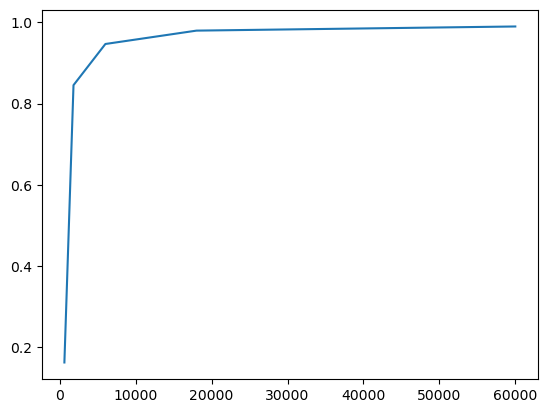

In [76]:
plt.plot(training_szs,accuracies_sz);

- **Effect of Increasing Training Samples:**
  - As the number of training samples increases:
    - Accuracy shows a noticeable improvement.
    - With 600 samples, accuracy is relatively low at 16.3%.
    - A substantial increase is observed with 1800 samples (84.54%).
    - Further improvements are seen with 6000 (94.67%), 18000 (97.96%), and 60000 samples (98.98%).
  - We can see significant performance improvement after 6000 samples only by adding large amount of data 
  - This trend suggests that having more diverse and abundant data positively impacts model performance, leading to better generalization and accuracy.


## TranformerEncoder

In [ ]:
import torch
import torch.nn as nn

# Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        
        # Self-attention layer
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        
        # First linear layer and its normalization
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.norm1 = nn.LayerNorm(d_model)
        
        # Second linear layer and its normalization
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Self-attention layer
        src1, _ = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        
        # Residual connection and dropout for the first sub-layer
        src = src + self.dropout(src1)
        
        # Layer normalization for the first sub-layer
        src = self.norm1(src)
        
        # First feedforward layer and its activation function
        src2 = self.linear2(self.dropout(nn.functional.relu(self.linear1(src))))
        
        # Residual connection and dropout for the second sub-layer
        src = src + self.dropout(src2)
        
        # Layer normalization for the second sub-layer
        src = self.norm2(src)
        
        return src

# ViT inspired classification head
class ViTClassHead(nn.Module):
    def __init__(self,in_features, num_classes):
        super(ViTClassHead, self).__init__()
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.fc(x)

# Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_chans=1, num_classes=10, d_model=4, nhead=8, num_layers=2):
        super(VisionTransformer, self).__init__()
        
        # Patch Embedding
        # Alternative patch embedding implementation
        self.patch_embed = nn.Conv2d(in_chans, d_model, kernel_size=patch_size, stride=patch_size, bias=False)

        # Positional Embedding => Batch size, number of patches + classification token, embedding dimension
        self.pos_embed = nn.Parameter(torch.zeros(1, (img_size // patch_size) ** 2 + 1, d_model))
        
        # Transformer Encoder Blocks
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(d_model, nhead) for _ in range(num_layers)])

        # self.fc = nn.Linear(in_features, num_classes)
    
        # Classification Head
        self.classification_head = ViTClassHead(33, num_classes)

    def forward(self, x):
        # Flatten and embed patches
        x = self.patch_embed(x)
        print(x.shape) # [8, 64, 4, 4]

        #[batch size,num_patch,patch_height,patch_width]
            # Flatten the spatial dimensions
        x = x.flatten(2).transpose(1, 2)
        
        print(x.shape) # [8, 16, 64]

             #[batch size,num_patch,patch_size_flattened] and then transpose

        # Concatenate positional embedding
        x = torch.cat([x,self.pos_embed.expand(x.size(0), -1, -1)], dim=1)
        print(x.shape) #torch.Size([8, 33, 64])
        
        # Encode with Transformer layers
        for layer in self.transformer_encoder:
            x = layer(x)

        print(x.shape) #torch.Size([8, 33, 64])

        # Use the first token for classification (similar to ViT)
        x = x[:, :,0]
        print(x.shape) #torch.Size([8, 33])

        # Use classification head
        x = self.classification_head(x)
        print(x.shape) #torch.Size([8, 10]

        return x

# torch.Size([8, 1, 28, 28])
# torch.Size([8, 16, 4, 4])
# torch.Size([8, 16, 16])
# torch.Size([8, 33, 16])
# torch.Size([8, 33, 16])
# torch.Size([8, 16])
# torch.Size([8, 10])


In [26]:
# Step 2: Create an instance of the VisionTransformer model
model = VisionTransformer(img_size=28, patch_size=7, in_chans=1, num_classes=10, d_model=64, nhead=8, num_layers=2)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = build_optimizer(model, wandb.config.optimizer, wandb.config.learning_rate)
optimizer = torch.optim.Adam(model.parameters())


# Training loop
for epoch_number in range(5):  # Number of epochs
    correct = 0
    total = 0
    print('EPOCH {}:'.format(epoch_number + 1))
    avg_loss = train_one_epoch(model,training_loader,loss_fn,optimizer,device,epoch_number,None,None,write=False)
    avg_vloss,v_acc = test_one_epoch(model,validation_loader,loss_fn,device,None)

    # wandb.log({"train_loss":avg_loss,"vloss":avg_vloss,"accuracy":v_acc})
    
    print('LOSS train {} valid {} ACC {}'.format(avg_loss, avg_vloss,v_acc))
    break

# wandb.save("model_ViT_6k.pth")

# Finish the run
# run.finish()

EPOCH 1:
torch.Size([8, 64, 4, 4])
torch.Size([8, 16, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33])
torch.Size([8, 10])
torch.Size([8, 64, 4, 4])
torch.Size([8, 16, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33])
torch.Size([8, 10])
torch.Size([8, 64, 4, 4])
torch.Size([8, 16, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33])
torch.Size([8, 10])
torch.Size([8, 64, 4, 4])
torch.Size([8, 16, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33])
torch.Size([8, 10])
torch.Size([8, 64, 4, 4])
torch.Size([8, 16, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33])
torch.Size([8, 10])
torch.Size([8, 64, 4, 4])
torch.Size([8, 16, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33])
torch.Size([8, 10])
torch.Size([8, 64, 4, 4])
torch.Size([8, 16, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33, 64])
torch.Size([8, 33])
torch.Size([8, 10])
torch.Size([8, 64, 4, 4])

In [ ]:
print("6k ViT ==> ",v_acc)

In [59]:
run = wandb.init(project="CV_A1_Q2",name = "TransformerEncoder_60K")
wandb.config.learning_rate = 0.001
wandb.config.batch_size = 8
wandb.config.epoch = 5
wandb.config.optimizer = "adam"
pprint(wandb.config)

{'learning_rate': 0.001, 'batch_size': 8, 'epoch': 5, 'optimizer': 'adam'}


In [60]:
batch_size = wandb.config.batch_size
learning_rate = wandb.config.learning_rate
epochs = wandb.config.epoch

# num_training_samples = 6000
num_training_samples = 60000
training_loader, validation_loader = data_get_load_num_samp(batch_size, num_training_samples)

Training set has 60000 instances
Validation set has 10000 instances


In [58]:
# Step 2: Create an instance of the VisionTransformer model
model = VisionTransformer(img_size=28, patch_size=7, in_chans=1, num_classes=10, d_model=512, nhead=8, num_layers=2)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = build_optimizer(model, wandb.config.optimizer, wandb.config.learning_rate)
optimizer = torch.optim.Adam(model.parameters())

# Training loop
for epoch_number in range(1):  # Number of epochs
    correct = 0
    total = 0
    print('EPOCH {}:'.format(epoch_number + 1))
    avg_loss = train_one_epoch(model,training_loader,loss_fn,optimizer,device,epoch_number,None,None,write=False)
    avg_vloss,v_acc = test_one_epoch(model,validation_loader,loss_fn,device,None)

    # wandb.log({"train_loss":av'g_loss,"vloss":avg_vloss,"accuracy":v_acc})
    
    print('LOSS train {} valid {} ACC {}'.format(avg_loss, avg_vloss,v_acc))

# wandb.save("model_ViT_60K.pth")

# Finish the run
# run.finish()

EPOCH 1:
torch.Size([8, 1, 28, 28])
torch.Size([8, 512, 4, 4])
torch.Size([8, 16, 512])
torch.Size([8, 33, 512])
torch.Size([8, 33, 512])
torch.Size([8, 512])
torch.Size([8, 10])
torch.Size([8, 1, 28, 28])
torch.Size([8, 512, 4, 4])
torch.Size([8, 16, 512])
torch.Size([8, 33, 512])
torch.Size([8, 33, 512])
torch.Size([8, 512])
torch.Size([8, 10])
torch.Size([8, 1, 28, 28])
torch.Size([8, 512, 4, 4])
torch.Size([8, 16, 512])
torch.Size([8, 33, 512])
torch.Size([8, 33, 512])
torch.Size([8, 512])
torch.Size([8, 10])
torch.Size([8, 1, 28, 28])
torch.Size([8, 512, 4, 4])
torch.Size([8, 16, 512])
torch.Size([8, 33, 512])
torch.Size([8, 33, 512])
torch.Size([8, 512])
torch.Size([8, 10])
torch.Size([8, 1, 28, 28])
torch.Size([8, 512, 4, 4])
torch.Size([8, 16, 512])
torch.Size([8, 33, 512])
torch.Size([8, 33, 512])
torch.Size([8, 512])
torch.Size([8, 10])
torch.Size([8, 1, 28, 28])
torch.Size([8, 512, 4, 4])
torch.Size([8, 16, 512])
torch.Size([8, 33, 512])
torch.Size([8, 33, 512])
torch.Size([

KeyboardInterrupt: 

In [94]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=2)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)
        x = x.mean(dim = 1) 
        x = self.fc(x)
        return x

In [95]:
import wandb
from pprint import pprint

In [96]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [97]:
run = wandb.init(project="CV_A1_Q2",name = "TransformerModel_6K")
wandb.config.learning_rate = 0.001
wandb.config.batch_size = 64
wandb.config.epoch = 5
wandb.config.optimizer = "adam"
pprint(wandb.config)

accuracy,▁
train_loss,▁
vloss,▁
accuracy,0.1028
train_loss,23.21601
vloss,2.32569


{'learning_rate': 0.001, 'batch_size': 64, 'epoch': 5, 'optimizer': 'adam'}


In [98]:
batch_size = wandb.config.batch_size
learning_rate = wandb.config.learning_rate
epochs = wandb.config.epoch

num_training_samples = 6000
# num_training_samples = 60000
training_loader, validation_loader = data_get_load_num_samp(batch_size, num_training_samples)

Training set has 6016 instances
Validation set has 10000 instances


In [99]:
# Step 2: Create an instance of the VisionTransformer model
model = TransformerModel(input_dim = 28 * 28, hidden_dim = 256, output_dim = 10, num_layers = 2)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = build_optimizer(model, wandb.config.optimizer, wandb.config.learning_rate)
optimizer = torch.optim.Adam(model.parameters())


# Training loop
for epoch_number in range(wandb.config.epoch):  # Number of epochs
    correct = 0
    total = 0
    print('EPOCH {}:'.format(epoch_number + 1))
#######################
# Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    running_loss =0
    last_loss = 0
    losses=[]
    for i,data in enumerate(training_loader):
        inputs,labels = data
        inputs,labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(inputs.size(0), -1)
        optimizer.zero_grad()        
        outputs=model(inputs)
        loss = loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
        losses.append(loss.item())
        if i%1000 == 999:
            last_loss = running_loss/100
            print(f"{i+1}th batch => {last_loss}")
            running_loss = 0.
    if last_loss==0:
        avg_loss = np.mean(np.array(losses))
    else:
        avg_loss = last_loss
################################

    model.eval()
    running_loss =0
    last_loss = 0
    correct = 0
    test_loader = validation_loader
    with torch.no_grad():
        for i,data in enumerate(validation_loader):
            inputs,labels = data
            inputs,labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            
            outputs=model(inputs)
            
            loss = loss_fn(outputs,labels)
            running_loss +=loss.item()
            _,preds = torch.max(outputs,1)
            correct += (preds == labels).sum().item()
    v_acc = correct/len(test_loader.dataset)
    avg_vloss= running_loss/len(test_loader.dataset)
############################
    
    wandb.log({"train_loss":avg_loss,"vloss":avg_vloss,"accuracy":v_acc})
    
    print('LOSS train {} valid {} ACC {}'.format(avg_loss, avg_vloss,v_acc))

wandb.save("model_ViT_6k.pth")

# Finish the run
run.finish()

/home/srihari/miniconda3/envs/conda_cv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


EPOCH 1:
LOSS train 0.948887436947924 valid 0.007090409817546606 ACC 0.8619
EPOCH 2:
LOSS train 0.4229620489034247 valid 0.006002545506507158 ACC 0.8814
EPOCH 3:
LOSS train 0.4263200173352627 valid 0.004800592842698097 ACC 0.9051
EPOCH 4:
LOSS train 0.3359704148420628 valid 0.0046090925229713324 ACC 0.9104
EPOCH 5:
LOSS train 0.34182175423236605 valid 0.005484303507581353 ACC 0.8973


accuracy,▁▄▇█▆
train_loss,█▂▂▁▁
vloss,█▅▂▁▃
accuracy,0.8973
train_loss,0.34182
vloss,0.00548


In [100]:
print("6k ViT ==> ",v_acc)

6k ViT ==>  0.8973


In [101]:
run = wandb.init(project="CV_A1_Q2",name = "TransformerModel_60K")
wandb.config.learning_rate = 0.001
wandb.config.batch_size = 64
wandb.config.epoch = 5
wandb.config.optimizer = "adam"
pprint(wandb.config)

{'learning_rate': 0.001, 'batch_size': 64, 'epoch': 5, 'optimizer': 'adam'}


In [102]:
batch_size = wandb.config.batch_size
learning_rate = wandb.config.learning_rate
epochs = wandb.config.epoch

# num_training_samples = 6000
num_training_samples = 60000
training_loader, validation_loader = data_get_load_num_samp(batch_size, num_training_samples)

Training set has 60032 instances
Validation set has 10000 instances


In [103]:
# Step 2: Create an instance of the VisionTransformer model
model = TransformerModel(input_dim = 28 * 28, hidden_dim = 256, output_dim = 10, num_layers = 2)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = build_optimizer(model, wandb.config.optimizer, wandb.config.learning_rate)
optimizer = torch.optim.Adam(model.parameters())


# Training loop
for epoch_number in range(wandb.config.epoch):  # Number of epochs
    correct = 0
    total = 0
    print('EPOCH {}:'.format(epoch_number + 1))
#######################
# Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    running_loss =0
    last_loss = 0
    losses=[]
    for i,data in enumerate(training_loader):
        inputs,labels = data
        inputs,labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(inputs.size(0), -1)
        optimizer.zero_grad()        
        outputs=model(inputs)
        loss = loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
        losses.append(loss.item())
        if i%1000 == 999:
            last_loss = running_loss/100
            print(f"{i+1}th batch => {last_loss}")
            running_loss = 0.
    if last_loss==0:
        avg_loss = np.mean(np.array(losses))
    else:
        avg_loss = last_loss
################################

    model.eval()
    running_loss =0
    last_loss = 0
    correct = 0
    test_loader = validation_loader
    with torch.no_grad():
        for i,data in enumerate(validation_loader):
            inputs,labels = data
            inputs,labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            
            outputs=model(inputs)
            
            loss = loss_fn(outputs,labels)
            running_loss +=loss.item()
            _,preds = torch.max(outputs,1)
            correct += (preds == labels).sum().item()
    v_acc = correct/len(test_loader.dataset)
    avg_vloss= running_loss/len(test_loader.dataset)
############################
    
    wandb.log({"train_loss":avg_loss,"vloss":avg_vloss,"accuracy":v_acc})
    
    print('LOSS train {} valid {} ACC {}'.format(avg_loss, avg_vloss,v_acc))

wandb.save("model_ViT_60k.pth")

# Finish the run
run.finish()

EPOCH 1:


/home/srihari/miniconda3/envs/conda_cv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


LOSS train 0.4169465715188716 valid 0.0035603805648162963 ACC 0.929
EPOCH 2:
LOSS train 0.2101337081019971 valid 0.002652829633979127 ACC 0.9458
EPOCH 3:
LOSS train 0.1635349067980483 valid 0.002282949787774123 ACC 0.9552
EPOCH 4:
LOSS train 0.1377259057823386 valid 0.0024871663068421184 ACC 0.9503
EPOCH 5:
LOSS train 0.12256830568903926 valid 0.002051530849467963 ACC 0.9602


accuracy,▁▅▇▆█
train_loss,█▃▂▁▁
vloss,█▄▂▃▁
accuracy,0.9602
train_loss,0.12257
vloss,0.00205


In [104]:
print("60k ViT ==> ",v_acc)

60k ViT ==>  0.9602


- **Performance Comparison: CNN vs. TransformerEncoder**
  - **6K Images:**
    - CNN: 94% Accuracy
    - TransformerEncoder: 89% Accuracy
    - The CNN outperformed the TransformerEncoder with 6K images, indicating that the CNN architecture might be more effective for less data.
    - We can infer that Transformer model needs more data to train effectively

  - **60K Images:**
    - CNN: 98% Accuracy
    - TransformerEncoder: 96% Accuracy
    - While the CNN still achieved a slightly higher accuracy, the TransformerEncoder demonstrated a significant improvement from the 6K scenario. The gap between the two models decreased, suggesting that the TransformerEncoder benefits more from a larger dataset.
    - Also the training time for Transformer architecture was faster compared to CNN architecture while both gave similar results
    - Fine tuning the Transformer model might give better results
